**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.**

In [1]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install git+https://github.com/michalgregor/class_utils.git

  Cloning https://github.com/michalgregor/class_utils.git to /tmp/pip-req-build-unzz_q8c
  Running command git clone -q https://github.com/michalgregor/class_utils.git /tmp/pip-req-build-unzz_q8c
     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 112kB 48.2MB/s 
     |████████████████████████████████| 57.7MB 69kB/s 
     |████████████████████████████████| 2.0MB 39.5MB/s 
  Created wheel for class-utils: filename=class_utils-0.1-cp36-none-any.whl size=6463 sha256=31d3275c6310eee0da9573c4a64a355ab96ae6c5c03ea416e0b8ded80fb287a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-unngni_3/wheels/0c/d3/63/b380d96ed74ced47fcdb67bfb9aee184bfdc970b956a65096d
  Created wheel for lime: filename=lime-0.2.0.0-cp36-none-any.whl size=284181 sha256=ed183a5b42521ef7fc052841b46491e1d0f324a979994838d6b11dfe3e7e265e
  Stored in directory: /root/.cache/pip/wheels/22/f2/ec/e5ebd07348b2b1ac722e91c2f549fcc220f7d5f25497a61232
  Created wheel for pdpbox: filename=PDPb

In [2]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import pandas as pd
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, KBinsDiscretizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from class_utils import error_histogram

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
#@title -- Downloading Data -- { display-mode: "form" }
!mkdir -p output
!mkdir -p data
!wget -nc -O data/sigmoid_regression_data.csv https://www.dropbox.com/s/p5q7gzupa2ndw55/sigmoid_regression_data.csv?dl=1

--2020-04-23 13:05:45--  https://www.dropbox.com/s/p5q7gzupa2ndw55/sigmoid_regression_data.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/p5q7gzupa2ndw55/sigmoid_regression_data.csv [following]
--2020-04-23 13:05:45--  https://www.dropbox.com/s/dl/p5q7gzupa2ndw55/sigmoid_regression_data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0d72abd126ab2650b2703a2dc2.dl.dropboxusercontent.com/cd/0/get/A2bcwAkwH0460bFaUrPlXhMvGf4nIgZqTsXVzvDYHJ4vmnbUBhA6Yc9tr7vcVSg3rkgVZLc9RCsfwoRULdED3S39kOY3bLLDkgRbommdAbAuvEZtb5zFw2nzn0rZKT_dY94/file?dl=1# [following]
--2020-04-23 13:05:45--  https://uc0d72abd126ab2650b2703a2dc2.dl.dropboxusercontent.com/cd/0/get/A2bcwAkwH0460bFaUrPlXhMvGf4nIgZqTsXVzvDYHJ4vmnbUBhA6Yc9tr7vcVSg3rkg

# Optimization-based Machine Learning

As our next example we will introduce a very simple application of optimization in the context of machine learning. Our goal will be to carry out regression: we will get input and output data and we will be trying to identify the function, which produces such a relationship.

This kind of task is easily transformed to an optimization problem. We will assume that we have a parametric function $f_\theta(\mathbf{x})$, the character of which is determined by a parameter vector $\theta$. Our goal will be to find parameters that will minimize the error of model $f_\theta(\mathbf{x})$ on out dataset.

Let our dataset be composed of samples $(\mathbf{x_i}, \mathbf{y_i})$, where $\mathbf{x_i}$ is the input and $\mathbf{y}_i$ is the desired output for sample $i$. We can then formalize our goal as the following optimization problem:

\begin{equation}
\theta^* = \underset{\theta}{\arg\max} \sum_{(\mathbf{x}_i, \mathbf{y}_i)} \mathcal{L}(f_\theta(\mathbf{x}_i), \mathbf{y}_i)
\end{equation}
i.e. we want to find a parameter vector $\theta^*$, which would minimize the difference between the actual and the desired outputs over the entire dataset in terms of some loss function: e.g. the **squared error**.

## The Dataset

We will start the definition of our regression problem by loading the dataset – our data will be from a noisy sigmoid curve and it will be read from a CSV file. Given that we have loaded and preprocessed the same data before, we will not repeat the exercise here. The necessary code is in the following cell and it is hidden for the sake of brevity.

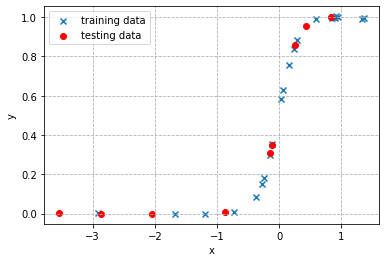

In [4]:
#@title -- Data Loading and Preprocessing; X_train, Y_train, X_test, Y_test -- { display-mode: "form" }
df = pd.read_csv("data/sigmoid_regression_data.csv")

# we create a discretized version of the y column
# to allow for stratification
kbins = KBinsDiscretizer(6, encode='ordinal')
y_stratify = kbins.fit_transform(df[['y']])

# we split the dataset into train and test
df_train, df_test = train_test_split(df, stratify=y_stratify,
                                 test_size=0.3, random_state=4)

# we specify the inputs and the outputs
categorical_inputs = []
numeric_inputs = ['x']
output = 'y'

# we create the pipeline
input_preproc = make_column_transformer(
    (make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OrdinalEncoder()),
     categorical_inputs),
    
    (make_pipeline(
        SimpleImputer(),
        StandardScaler()),
     numeric_inputs)
)

# we fit and apply the pipeline on the train set
X_train = input_preproc.fit_transform(df_train[categorical_inputs+numeric_inputs]).reshape(-1)
Y_train = df_train[output].values

# we apply the same pipeline to the test set,
# taking care to use transform and not fit_transform
X_test = input_preproc.transform(df_test[categorical_inputs+numeric_inputs]).reshape(-1)
Y_test = df_test[output].values

# we plot the data for visual inspection
plt.scatter(X_train, Y_train, marker='x', label="training data")
plt.scatter(X_test, Y_test, c='r', label="testing data")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(ls='--')
plt.legend()
plt.savefig("output/regression_data.pdf", bbox_inches='tight', ppad_inches=0)

---

## Task 1: Defining the Regression Function

The shape of the relationship that we have just visualized is conspicuously similar to the sigmoid (logistic) curve, which is defined as follows:
\begin{equation}
\sigma(x) = \frac{1}{1 + e^{-x}}.
\end{equation}
However, it seems that the curve is shifted by a bit in the direction of the $x$ axis and its steepness may also not be the same. We will therefore form our regression model by piping the input to the sigmoid function through a linear transform, the parameters $a$ and $c$ of which we will learn from data. Our entire regression model will then look as follows:
\begin{align}
u &= ax + c \\
\sigma(u) &= \frac{1}{1 + e^{-u}}.
\end{align}

Or folded into a single function:
\begin{equation}
\mathrm{f}(x, a, c) = \frac{1}{1 + e^{-ax - c}}
\end{equation}

**Use the ``sympy`` package to symbolically define our regression model as function $f(x, a, c)$.**

---

In [9]:
symx, syma, symc = sp.symbols('x a c')

symf = 1/(1+sp.exp(-syma*symx-symc))

f = lambdify([symx, syma, symc], symf, "numpy")

symf

1/(exp(-a*x - c) + 1)

We will check function ``f(x, a, c)`` by visualizing it:

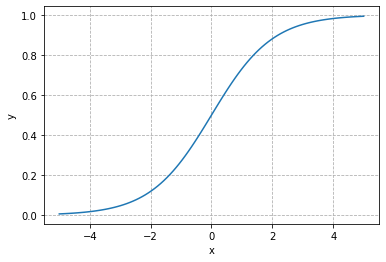

In [10]:
#@title -- Regression Function Visualization -- { display-mode: "form" }
xx = np.linspace(-5, 5, 100)
a = 1; c = 0
yy = [f(x, a, c) for x in xx]

plt.plot(xx, yy)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(ls='--')

plt.savefig("output/sigmoid.pdf", bbox_inches="tight", pad_inches=0)

## Our Objective Function and Its Gradient

As already stated, our goal is to minimize the error on our dataset, i.e.

\begin{equation}
\theta^* = \underset{\theta}{\arg\max} \sum_{(\mathbf{x}_i, \mathbf{y}_i)} \mathcal{L}(f_\theta(\mathbf{x}_i), \mathbf{y}_i)
\end{equation}

The outer sum can be ignored when computing the gradient. The following holds because of the linearity of differentiation:

\begin{equation}
\nabla \sum_{(\mathbf{x}_i, \mathbf{y}_i)} \mathcal{L}(f_\theta(\mathbf{x}_i), \mathbf{y}_i) = \sum_{(\mathbf{x}_i, \mathbf{y}_i)} \nabla \mathcal{L}(f_\theta(\mathbf{x}_i), \mathbf{y}_i)
\end{equation}
and it therefore suffices to solve the inner part of the sum and then sum up the gradients for all the individual samples from the dataset.

If we use the squared error as our loss function, we will obtain:

\begin{equation}
\mathcal{L}(f_\theta(\mathbf{x}_i), \mathbf{y}_i) = \left(
    f_\theta(\mathbf{x}_i) - \mathbf{y}_i
\right)^2.
\end{equation}

Let us now define this function symbolically and determine its gradient (only w.r.t. parameters $a$ and $c$ because we are only going to be tuning those):

In [0]:
symy = sp.symbols('y')
symL = (symf - symy)**2

In [12]:
L = lambdify((symx, symy, syma, symc), symL, "numpy")

sym_grad_L = sp.Matrix([symL]).jacobian([syma, symc])
grad_L_func = lambdify((symx, symy, syma, symc), sym_grad_L, "numpy")

sym_grad_L

Matrix([[2*x*(-y + 1/(exp(-a*x - c) + 1))*exp(-a*x - c)/(exp(-a*x - c) + 1)**2, 2*(-y + 1/(exp(-a*x - c) + 1))*exp(-a*x - c)/(exp(-a*x - c) + 1)**2]])

Having made such definitions we will substitute all the necessary arguments ($x$, $y$, $a$, $c$) into ``grad_L``, but the function will only return a 2-element vector containing the partial derivatives w.r.t. $a$ and $c$. E.g.:

In [13]:
x = 0; y = 1; a = 1; c = 0
print("L:\t\t{}".format(L(x, y, a, c)))
print("grad_L:\t\t{}".format(grad_L_func(x, y, a, c)))

L:		0.25
grad_L:		[[-0.   -0.25]]


## The Total Loss and Its Gradient

As we already know we will obtain the total loss as the sum of the losses over the individual samples and the same goes for the total gradient, which will be the sum of the gradients over the individual samples. Let us therefore define two functions, which will allow us to compute both of these:

In [0]:
def sumL(a, c, X, Y):
    L_sum = 0
    
    for x, y in zip(X, Y):
        L_sum += L(x, y, a, c)
        
    return L_sum

In [0]:
def grad_sumL(a, c, X, Y):
    grad_sum = np.zeros(2)
    
    for x, y in zip(X, Y):
        grad_sum = grad_sum + grad_L_func(x, y, a, c)
        
    return grad_sum

To make sure that everything works we can test our functions now:

In [16]:
print(sumL(a, c, X_train, Y_train))
print(grad_sumL(a, c, X_train, Y_train))

1.2417730427762137
[[-1.2288481  -0.42606021]]


## Minimizing the Objective Function

As our next step we only need to apply function ``minimize`` to minimize the total loss and to visualize the resulting regression curve. The minimization can be applied as follows:

In [0]:
res = minimize(fun=lambda xx: sumL(*xx, X_train, Y_train),
               x0=np.random.uniform(0, 1, 2),
               method='L-BFGS-B',
               jac=lambda xx: grad_sumL(*xx, X_train, Y_train)
              )

a, c = res.x

## Testing Our Regression Model

We will get the outputs of our regression model on the training data and compute the performance indicators.

In [0]:
y_test = [f(x, a, c) for x in X_test]

In [19]:
mse = mean_squared_error(Y_test, y_test)
mae = mean_absolute_error(Y_test, y_test)

print("MSE: {}".format(mse))
print("MAE: {}".format(mae))

MSE: 1.045919271018508e-05
MAE: 0.0026462822625139006


To get a fuller idea we can also plot the histogram of outputs and errors just as we did in one of our earlier notebooks:

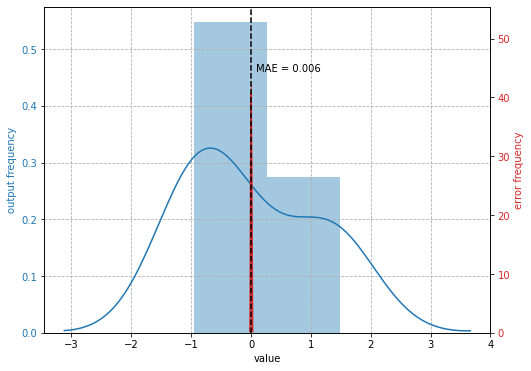

In [20]:
#@title -- Histogram of Outputs and Errors -- { display-mode: "form" }
plt.figure(figsize=(8, 6))
error_histogram(Y_test, y_test, Y_fit_scaling=Y_train)
plt.savefig("output/error_output_histogram.pdf", bbox_inches='tight', ppad_inches=0)

Given that our data is 2-dimensional, it will be even more useful to visualize the original data and our resulting regression curve. This will give us a strong intuition as to whether the regression curve behaves as it should:

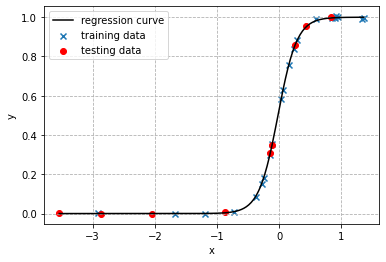

In [21]:
#@title -- Regression Curve vs. Data -- { display-mode: "form" }
x_min = min(np.min(X_train), np.min(X_test))
x_max = max(np.max(X_train), np.max(X_test))

xx = np.linspace(x_min, x_max, 250).reshape((-1, 1))
yy = [f(x, a, c) for x in xx]

plt.scatter(X_train, Y_train, marker='x', label="training data")
plt.scatter(X_test, Y_test, c='r', label="testing data")

plt.plot(xx, yy, label="regression curve", c='k')

plt.xlabel('x')
plt.ylabel('y')
plt.grid(ls='--')
plt.legend()

plt.savefig("output/regression.pdf", bbox_inches="tight", pad_inches=0)

## An Easier Implementation of Regression Using ``curve_fit``

There are, of course, other and simpler tools for performing regression. We can mention ``scipy.optimize.curve_fit`` as a good example of one such general function. When applying it we only need to enter the regression function in the prescribed form (and optionally also its gradient) and we do not need to consider things such as the iteration of the dataset etc.

Using ``scipy.optimize.curve_fit`` we could simplify our example as follows:

In [0]:
def sigmoid(x, a, c):
    return 1 / (1 + np.exp(-a*x - c))

In [0]:
popt, _ = curve_fit(sigmoid, X_train.reshape(-1), Y_train.reshape(-1))

### Evaluation on the Test Set

In [0]:
y_test = sigmoid(X_test, *popt)

In [25]:
mse = mean_squared_error(Y_test, y_test)
mae = mean_absolute_error(Y_test, y_test)

print("MSE: {}".format(mse))
print("MAE: {}".format(mae))

MSE: 1.0458158668184867e-05
MAE: 0.002646063119858569


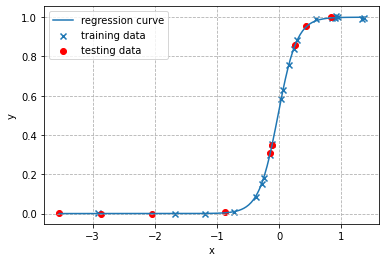

In [26]:
#@title -- Regression Curve vs. Data -- { display-mode: "form" }
x_min = min(np.min(X_train), np.min(X_test))
x_max = max(np.max(X_train), np.max(X_test))

xx = np.linspace(x_min, x_max, 250).reshape((-1, 1))
yy = sigmoid(xx, *popt)

plt.scatter(X_train, Y_train, marker='x', label="training data")
plt.scatter(X_test, Y_test, c='r', label="testing data")

plt.plot(xx, yy, label="regression curve")

plt.xlabel('x')
plt.ylabel('y')
plt.grid(ls='--')
plt.legend()

plt.savefig("output/regression2.pdf", bbox_inches="tight", pad_inches=0)